<a href="https://colab.research.google.com/github/jaysmerrill/Yaquina_Bay_Seiching/blob/main/seiche_prediction_realtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STDMET years:   0%|          | 0/18 [00:00<?, ?yr/s]

SWDEN years:   0%|          | 0/18 [00:00<?, ?yr/s]

NOAA wind 9435380:   0%|          | 0/18 [00:00<?, ?chunk/s]

HMSC months:   0%|          | 0/214 [00:00<?, ?mo/s]

NOAA WL 9435380:   0%|          | 0/210 [00:00<?, ?chunk/s]

[WL] Station 9435380 rows: 1,556,160  range: 2008-01-01 00:00:00 → 2025-10-01 23:54:00

Selected ONE best lag per base:
  wind9435380_u__lag_60min        (base=wind9435380_u, importance=0.062998, lag=60 min)
  wind9435380_speed__lag_120min   (base=wind9435380_speed, importance=0.052086, lag=120 min)
  Hm0_sea__lag_120min             (base=Hm0_sea, importance=0.038669, lag=120 min)
  MWD__lag_30min                  (base=MWD, importance=0.029582, lag=30 min)
  APD__lag_90min                  (base=APD, importance=0.028782, lag=90 min)
  DPD__lag_150min                 (base=DPD, importance=0.024596, lag=150 min)
  Hm0_swell__lag_60min            (base=Hm0_swell, importance=0.017072, lag=60 min)
  wind9435380_dir__lag_120min     (base=wind9435380_dir, importance=0.015000, lag=120 min)
  wind9435380_v__lag_120min       (base=wind9435380_v, importance=0.014556, lag=120 min)
  Hs__lag_240min                  (base=Hs, importance=0.008856, lag=240 min)

=== Horizon 60 min ===
[60m] Windows a

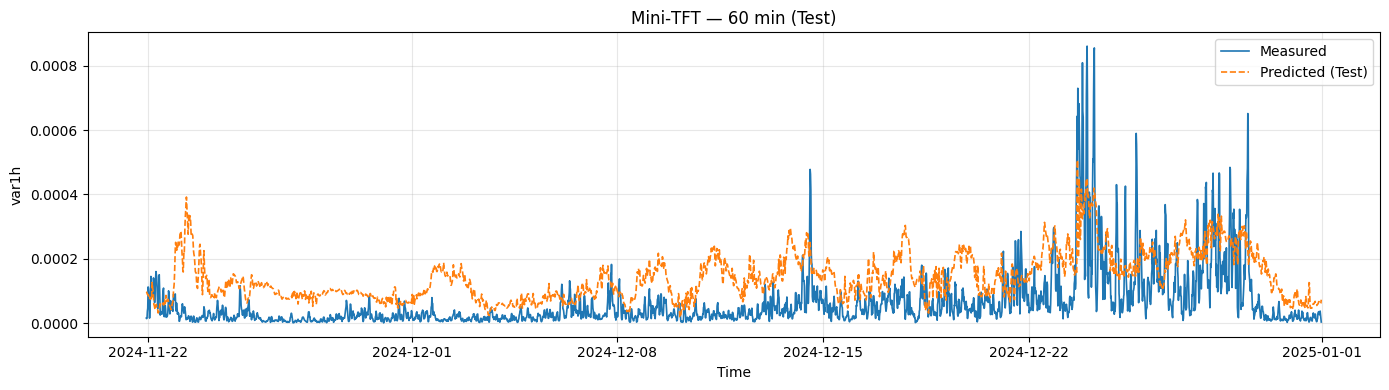

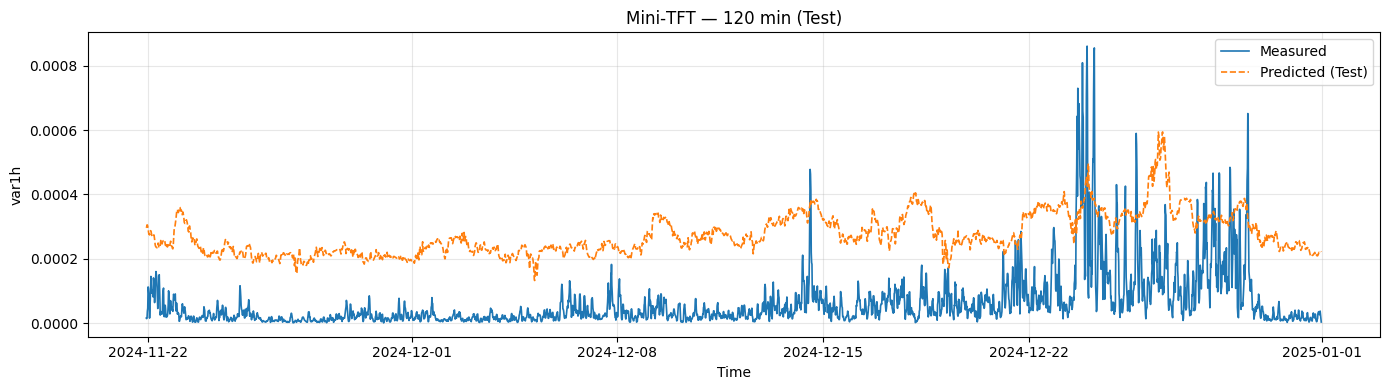

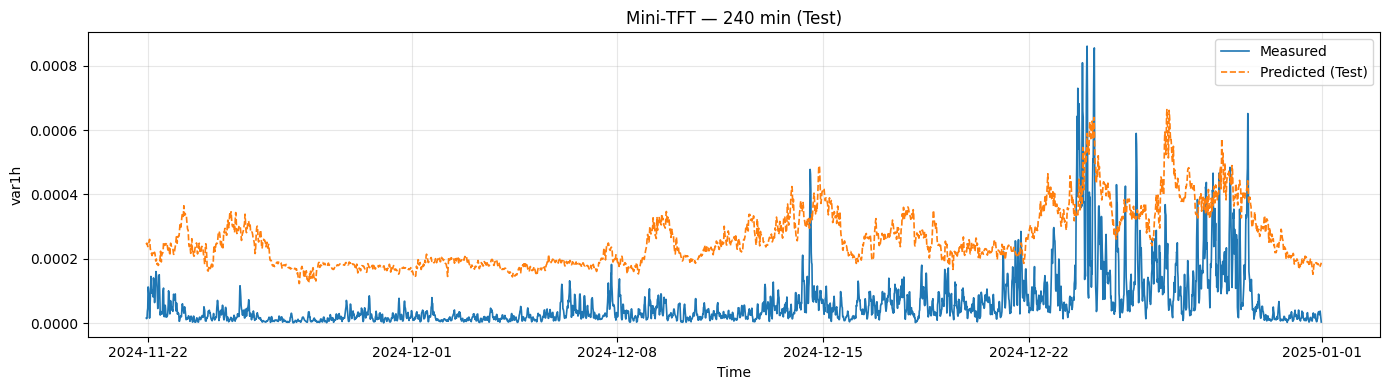


Final selected lag channels (one per base):
   wind9435380_u__lag_60min
   wind9435380_speed__lag_120min
   Hm0_sea__lag_120min
   MWD__lag_30min
   APD__lag_90min
   DPD__lag_150min
   Hm0_swell__lag_60min
   wind9435380_dir__lag_120min
   wind9435380_v__lag_120min
   Hs__lag_240min


In [2]:
# ============================================================
# Seiche Pipeline — WL fix + diagnostics
#  • Switch WL station default to 9435380 (same as wind, per your comment)
#  • Adjustable centered variance window via VAR_WIN_HOURS
#  • Robust NOAA WL fetch + helpful prints if nothing returns
#  • Lowercase 'h' time alias to avoid pandas FutureWarning
# ============================================================
import io, gzip, requests, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from contextlib import nullcontext
from sklearn.metrics import r2_score

# Progress bars (prints cleanly in Kaggle Script console)
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, *a, **k):  # fallback if tqdm unavailable
        return x

# -------------------
# USER KNOBS
# -------------------
YEARS               = list(range(2008, 2026))   # swden/stdmet years
DT_MINUTES          = 6                         # base grid step (minutes)
VAR_WIN_HOURS       = 1.0                       # <== centered rolling-variance window (hours)
MAX_GAP_HOURS       = 5
USE_UNIFIED_GAP_MASK= False
HISTORY_HOURS       = 12
HORIZONS_MIN        = [60, 120, 240]
PRIMARY_HORIZON     = 60

# If you already loaded df_wl6 yourself (with columns ['time','wl']), set False.
WL_USE_FETCH        = True

# NOAA wind (CO-OPS) fetch window (chunked)
NOAA_BEGIN_DATE     = "20080101"
NOAA_END_DATE       = "20251001"
NOAA_WIND_STATION   = "9435380"   # Newport / South Beach

# Water level (response) station and date range — default to 9435380 per your note
NOAA_WL_STATION     = "9435380"
WL_BEGIN_DATE       = "20080101"
WL_END_DATE         = "20251001"

NOAA_CHUNK_DAYS     = 365

# HMSC monthly archive (backfill for wind)
HMSC_BASE_URL       = "http://weather.hmsc.oregonstate.edu/weather/weatherproject/archive/{yyyy}/HMSC_{yyyymm}.dat"
HMSC_UTC_OFFSET_H   = +8  # PST → UTC

# lag caps (minutes)
NON_EQ_MAX_LAG_MIN  = 4 * 60
EQ_MAX_LAG_MIN      = 24 * 60
TOP_LAG_FEATURES    = 12
PER_BASE_CAP        = 1

# spike emphasis on target
WEIGHT_SPIKES       = True
SPIKE_P90           = 0.90
SPIKE_WEIGHT        = 2.0

# time splits
TRAIN_END           = pd.Timestamp("2018-12-31 23:59:59")
VAL_END             = pd.Timestamp("2022-12-31 23:59:59")
MAX_SAMPLES_SPLIT   = 60_000

# ---- Plotting controls ----
PRED_SPLIT          = "test"     # "test" or "val"
PRED_START          = pd.Timestamp("2022-01-01 00:00:00")
PRED_END            = pd.Timestamp("2022-01-31 23:59:59")
PLOT_LAST_DAYS      = 40

# -------------------
# Robust HTTP session
# -------------------
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def _make_session():
    s = requests.Session()
    retry = Retry(total=4, backoff_factor=0.6, status_forcelist=(429,500,502,503,504),
                  allowed_methods=["HEAD","GET","OPTIONS"], raise_on_status=False)
    s.headers.update({"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) SeicheFetcher/1.0", "Accept":"*/*"})
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s

session = _make_session()

# -------------------
# Helpers
# -------------------

def _ndbc_to_float(tok:str) -> float:
    s = str(tok).strip()
    if s == "" or s.upper() == "MM":
        return np.nan
    if re.fullmatch(r"-?9+(\.0+)?", s):  # 99, 9999, 999.00, etc. -> NaN
        return np.nan
    try:
        return float(s)
    except Exception:
        return np.nan

def _datestr(dt) -> str:
    return pd.Timestamp(dt).strftime("%Y%m%d")

# -------------------
# NDBC 46050 STDMET (Hs/DPD/APD/MWD)
# -------------------
STDMET_DIRECT_PAT = "https://www.ndbc.noaa.gov/data/historical/stdmet/46050h{year}.txt.gz"
STDMET_PHP_PAT    = "https://www.ndbc.noaa.gov/view_text_file.php?filename=46050h{year}.txt.gz&dir=data/historical/stdmet/"

def fetch_stdmet_year(year:int)->str|None:
    for url in (STDMET_DIRECT_PAT.format(year=year), STDMET_PHP_PAT.format(year=year)):
        try:
            r = session.get(url, timeout=30)
            if r.status_code != 200 or not r.content: continue
            data = r.content
            try:
                with gzip.GzipFile(fileobj=io.BytesIO(data)) as gz:
                    return gz.read().decode("utf-8", errors="ignore")
            except OSError:
                try:
                    return data.decode("utf-8", errors="ignore")
                except Exception:
                    continue
        except Exception:
            continue
    return None

def parse_stdmet_text(txt:str)->pd.DataFrame:
    rows=[]
    for ln in txt.splitlines():
        if not ln or ln.lstrip().startswith("#"): continue
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 6: continue
        # Expect time fields: YY(or YYYY) MM DD hh mm
        y,mo,dy,hh,mi = parts[:5]
        try:
            y=int(y); mo=int(mo); dy=int(dy); hh=int(hh); mi=int(mi)
            year = 2000+y if y<100 else y
            ts = pd.Timestamp(year=year, month=mo, day=dy, hour=hh, minute=mi, tz="UTC").tz_localize(None)
        except Exception:
            continue
        vals = parts[5:]
        if len(vals) < 13: vals = (vals + ["MM"]*13)[:13]
        vals = [_ndbc_to_float(v) for v in vals]
        rows.append([ts] + vals)
    if not rows:
        return pd.DataFrame()
    cols = ["time","WDIR","WSPD","GST","WVHT","DPD","APD","MWD","PRES","ATMP","WTMP","DEWP","VIS","TIDE"]
    df = pd.DataFrame(rows, columns=cols).sort_values("time").drop_duplicates("time")
    df = df.rename(columns={"WVHT":"Hs"}).reset_index(drop=True)
    for c,thr in [("Hs",50.0),("DPD",50.0),("APD",50.0)]:
        if c in df.columns:
            m = df[c] > thr
            if m.any(): df.loc[m,c]=np.nan
    if "MWD" in df.columns:
        df.loc[(df["MWD"]<0)|(df["MWD"]>360),"MWD"]=np.nan
    keep = ["time","Hs","DPD","APD","MWD"]
    for k in keep:
        if k not in df.columns: df[k]=np.nan
    return df[keep]

# === PROGRESS-ENABLED ===

def build_stdmet(years: List[int]) -> pd.DataFrame:
    frames = []
    for y in tqdm(years, desc="STDMET years", unit="yr"):
        txt = fetch_stdmet_year(y)
        if not txt: continue
        dfy = parse_stdmet_text(txt)
        if dfy.empty: continue
        frames.append(dfy)
    if not frames: return pd.DataFrame(columns=["time","Hs","DPD","APD","MWD"])
    df = pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time")
    return df.reset_index(drop=True)

# Build STDMET
df_stdmet = build_stdmet(YEARS)

# -------------------
# NDBC 46050 SWDEN (spectral density) → Hm0_swell / Hm0_sea
# -------------------
SWDEN_PHP_PATS = [
    "https://www.ndbc.noaa.gov/view_text_file.php?filename=46050w{year}.txt.gz&dir=data/historical/swden/",
    "https://www.ndbc.noaa.gov/view_text_file.php?filename=46050w{year}.txt.gz&dir=data/swden/46050/",
]

def fetch_swden_year(year:int)->str|None:
    for url in SWDEN_PHP_PATS:
        try:
            r = session.get(url.format(year=year), timeout=40)
            if r.status_code==200 and r.text and "Page Not Found" not in r.text:
                return r.text
        except Exception:
            continue
    return None

def split_swden_blocks(lines:List[str]):
    """Return (header_lines, freq_line, data_lines)"""
    header=[]; i=0
    while i<len(lines) and lines[i].startswith("#"):
        header.append(lines[i]); i+=1
    while i<len(lines) and not lines[i].strip():
        i+=1
    freq_line = lines[i].rstrip("\n") if i<len(lines) else None
    i += 1 if i<len(lines) else 0
    data=[ln for ln in lines[i:] if ln.strip()]
    return header, freq_line, data

def parse_swden_year(txt:str)->pd.DataFrame:
    lines = txt.splitlines()
    _, freq_line, data_lines = split_swden_blocks(lines)
    if not freq_line: return pd.DataFrame()
    freq_tokens = [t for t in re.split(r"\s+", freq_line.strip()) if t]
    if any(k in freq_tokens[:6] for k in ("YY","MM","DD","hh")):
        idx = lines.index(freq_line)
        j=idx+1
        while j<len(lines) and not lines[j].strip():
            j+=1
        if j<len(lines):
            freq_tokens = [t for t in re.split(r"\s+", lines[j].strip()) if t]
            data_lines  = [ln for ln in lines[j+1:] if ln.strip()]
        else:
            return pd.DataFrame()

    def _num(tok):
        try: return float(tok)
        except: return np.nan
    freqs = np.array([_num(t) for t in freq_tokens], dtype=float)
    freqs = freqs[np.isfinite(freqs)]
    if freqs.size==0: return pd.DataFrame()

    dfw = np.empty_like(freqs)
    if freqs.size==1:
        dfw[:] = 0.0
    else:
        dfw[1:-1] = 0.5*(freqs[2:] - freqs[:-2])
        dfw[0]    = freqs[1] - freqs[0]
        dfw[-1]   = freqs[-1] - freqs[-2]
        dfw = np.where(dfw<0, np.nan, dfw)

    i_swell = np.where(freqs <= 0.14)[0]
    i_sea   = np.where(freqs >  0.14)[0]

    rows=[]
    for ln in data_lines:
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 4: continue
        y,mo,dy,hh = parts[:4]
        try:
            y=int(y); mo=int(mo); dy=int(dy); hh=int(hh)
            year = 2000+y if y<100 else y
            ts = pd.Timestamp(year=year, month=mo, day=dy, hour=hh, tz="UTC").tz_localize(None)
        except Exception:
            continue
        vals = np.array([_ndbc_to_float(v) for v in parts[4:]], dtype=float)
        if vals.size != freqs.size:
            if vals.size < freqs.size:
                vals = np.pad(vals, (0, freqs.size - vals.size), constant_values=np.nan)
            else:
                vals = vals[:freqs.size]
        m0_swell = np.nansum(vals[i_swell] * dfw[i_swell]) if i_swell.size else np.nan
        m0_sea   = np.nansum(vals[i_sea]   * dfw[i_sea])   if i_sea.size   else np.nan
        hm0_swell = 4.0*np.sqrt(m0_swell) if np.isfinite(m0_swell) and m0_swell>=0 else np.nan
        hm0_sea   = 4.0*np.sqrt(m0_sea)   if np.isfinite(m0_sea)   and m0_sea>=0   else np.nan
        rows.append((ts, hm0_swell, hm0_sea))
    if not rows: return pd.DataFrame()
    df_out = pd.DataFrame(rows, columns=["time","Hm0_swell","Hm0_sea"]).sort_values("time").drop_duplicates("time").reset_index(drop=True)
    return df_out

# === PROGRESS-ENABLED ===

def build_swden(years: List[int]) -> pd.DataFrame:
    frames = []
    for y in tqdm(years, desc="SWDEN years", unit="yr"):
        txt = fetch_swden_year(y)
        if not txt: continue
        dfy = parse_swden_year(txt)
        if dfy.empty: continue
        frames.append(dfy)
    if not frames: return pd.DataFrame(columns=["time","Hm0_swell","Hm0_sea"])
    df = pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time")
    return df.reset_index(drop=True)

# Build SWDEN
df_swden = build_swden(YEARS)

# -------------------
# NOAA CO-OPS 9435380 wind (hourly) + HMSC fallback
# -------------------

def parse_noaa_wind_csv(txt:str)->pd.DataFrame:
    df = pd.read_csv(io.StringIO(txt))
    time_cols = [c for c in df.columns if str(c).strip().lower() in ("t","time","date time","date_time","date")]
    time_col = time_cols[0] if time_cols else df.columns[0]
    df["time"] = pd.to_datetime(df[time_col], errors="coerce", utc=True).dt.tz_localize(None)
    def _find(colnames, keys):
        keys = [k.lower() for k in keys]
        for c in colnames:
            s = str(c).lower()
            if any(k == s or k in s for k in keys): return c
        return None
    sp_col = _find(df.columns, ["s","speed"])   # m/s
    dir_col= _find(df.columns, ["d","dir","direction"])
    out = pd.DataFrame({"time":df["time"]})
    out["wind9435380_speed"] = pd.to_numeric(df[sp_col], errors="coerce") if sp_col else np.nan
    out["wind9435380_dir"]   = pd.to_numeric(df[dir_col], errors="coerce") if dir_col else np.nan
    out.loc[(out["wind9435380_dir"]<0)|(out["wind9435380_dir"]>360),"wind9435380_dir"]=np.nan
    out.loc[(out["wind9435380_speed"]<0)|(out["wind9435380_speed"]>100),"wind9435380_speed"]=np.nan
    th = np.deg2rad(out["wind9435380_dir"].to_numpy(dtype=float))
    s  = out["wind9435380_speed"].to_numpy(dtype=float)
    u = -s*np.sin(th); v=-s*np.cos(th)
    out["wind9435380_u"]=u.astype(np.float32)
    out["wind9435380_v"]=v.astype(np.float32)
    out = out.sort_values("time").dropna(subset=["time"]).drop_duplicates("time")
    return out.reset_index(drop=True)

# === PROGRESS-ENABLED ===

def fetch_noaa_wind_dataframe(begin_date:str, end_date:str, station:str, days_per_chunk:int=365) -> pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d")
    end   = pd.to_datetime(end_date,   format="%Y%m%d")
    chunks = []
    cur = start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        chunks.append((cur, chunk_end))
        cur = chunk_end + pd.Timedelta(days=1)
    frames=[]
    for a, b in tqdm(chunks, desc=f"NOAA wind {station}", unit="chunk"):
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(a)}&end_date={_datestr(b)}"
               f"&station={station}&product=wind&time_zone=gmt&interval=h&units=metric"
               "&application=SeichePipeline&format=csv")
        try:
            r = session.get(url, timeout=60)
            if r.status_code==200 and r.content:
                dfc = parse_noaa_wind_csv(r.content.decode("utf-8","ignore"))
                if not dfc.empty: frames.append(dfc)
        except Exception:
            pass
    if not frames:
        return pd.DataFrame(columns=["time","wind9435380_speed","wind9435380_dir","wind9435380_u","wind9435380_v"])
    df = pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time")
    return df.reset_index(drop=True)

# HMSC parsing

def fetch_hmsc_month_text(year:int, month:int) -> str|None:
    yyyymm = f"{year}{month:02d}"; url = HMSC_BASE_URL.format(yyyy=year, yyyymm=yyyymm)
    try:
        r = session.get(url, timeout=60)
        if r.status_code==200 and r.content:
            return r.content.decode("utf-8","ignore")
    except Exception:
        pass
    return None

def parse_hmsc_dat(txt:str) -> pd.DataFrame:
    lines = txt.splitlines(); start_idx=None
    for i,ln in enumerate(lines):
        s = ln.strip().strip('"')
        if s.startswith("TIMESTAMP"): start_idx=i; break
    if start_idx is None: return pd.DataFrame()
    content = "\n".join(lines[start_idx:])
    df = pd.read_csv(io.StringIO(content))
    def _try_time(x):
        try: return pd.to_datetime(x)
        except: return pd.NaT
    tt = df.iloc[:,0].apply(_try_time)
    df = df.loc[tt.notna()].copy()
    df.rename(columns={df.columns[0]:"TIMESTAMP"}, inplace=True)
    cols_lower = {c.lower():c for c in df.columns}
    AWS_col = cols_lower.get("aws"); AWD_col = cols_lower.get("awd")
    if AWS_col is None or AWD_col is None: return pd.DataFrame()
    out = pd.DataFrame()
    out["time"] = pd.to_datetime(df["TIMESTAMP"], errors="coerce") + pd.Timedelta(hours=HMSC_UTC_OFFSET_H)
    mph = pd.to_numeric(df[AWS_col], errors="coerce")
    spd_ms = mph * 0.44704
    dir_deg = pd.to_numeric(df[AWD_col], errors="coerce")
    dir_deg[(dir_deg<0)|(dir_deg>360)] = np.nan
    out["hmsc_speed_ms"]=spd_ms.astype("float32")
    out["hmsc_dir_deg"]=dir_deg.astype("float32")
    th = np.deg2rad(out["hmsc_dir_deg"].to_numpy(dtype=float)); s=out["hmsc_speed_ms"].to_numpy(dtype=float)
    u=-s*np.sin(th); v=-s*np.cos(th)
    out["hmsc_u"]=u.astype(np.float32); out["hmsc_v"]=v.astype(np.float32)
    out = out.sort_values("time").dropna(subset=["time"]).drop_duplicates("time")
    return out.reset_index(drop=True)

def month_iter(start:pd.Timestamp, end:pd.Timestamp):
    y,m = start.year, start.month
    while pd.Timestamp(year=y, month=m, day=1) <= end:
        yield (y,m)
        if m==12: y,m=y+1,1
        else: m+=1

# === PROGRESS-ENABLED ===

def fetch_hmsc_range(start:pd.Timestamp, end:pd.Timestamp)->pd.DataFrame:
    months = list(month_iter(start.normalize(), end.normalize()))
    frames=[]
    for y,m in tqdm(months, desc="HMSC months", unit="mo"):
        txt = fetch_hmsc_month_text(y,m)
        if not txt: continue
        dfm = parse_hmsc_dat(txt)
        if not dfm.empty:
            dfm = dfm[(dfm["time"]>=start-pd.Timedelta(days=1))&(dfm["time"]<=end+pd.Timedelta(days=1))]
            frames.append(dfm)
    if not frames: return pd.DataFrame(columns=["time","hmsc_speed_ms","hmsc_dir_deg","hmsc_u","hmsc_v"])
    df = pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time")
    return df.reset_index(drop=True)

def resample_hmsc_hourly(df_hmsc:pd.DataFrame)->pd.DataFrame:
    if df_hmsc.empty: return df_hmsc
    g = df_hmsc.set_index("time").sort_index()
    hourly_u = g["hmsc_u"].resample("h").mean()
    hourly_v = g["hmsc_v"].resample("h").mean()
    th = np.degrees(np.arctan2(-hourly_u.to_numpy(), -hourly_v.to_numpy())) % 360.0
    spd = np.sqrt(hourly_u.to_numpy()**2 + hourly_v.to_numpy()**2)
    out = pd.DataFrame({
        "time": hourly_u.index,
        "hmsc_u": hourly_u.values.astype("float32"),
        "hmsc_v": hourly_v.values.astype("float32"),
        "hmsc_speed_ms": spd.astype("float32"),
        "hmsc_dir_deg": th.astype("float32"),
    }).dropna(subset=["time"])
    return out.reset_index(drop=True)

# Build wind with fill

df_noaa_wind = fetch_noaa_wind_dataframe(NOAA_BEGIN_DATE, NOAA_END_DATE, NOAA_WIND_STATION, days_per_chunk=NOAA_CHUNK_DAYS)
if len(df_noaa_wind):
    fill_start, fill_end = df_noaa_wind["time"].min(), df_noaa_wind["time"].max()
else:
    candidates=[]
    if len(df_swden): candidates.append((df_swden["time"].min(), df_swden["time"].max()))
    if len(df_stdmet): candidates.append((df_stdmet["time"].min(), df_stdmet["time"].max()))
    if candidates:
        fill_start = min(a for a,_ in candidates); fill_end = max(b for _,b in candidates)
    else:
        fill_start = pd.Timestamp("2008-01-01"); fill_end=pd.Timestamp("2025-10-01")

df_hmsc_raw = fetch_hmsc_range(fill_start, fill_end)
df_hmsc_hour = resample_hmsc_hourly(df_hmsc_raw)

hourly_grid = pd.date_range(fill_start.floor("h"), fill_end.ceil("h"), freq="h")
noaa = (df_noaa_wind.set_index("time").reindex(hourly_grid).rename_axis("time").reset_index()) if len(df_noaa_wind) else pd.DataFrame({"time":hourly_grid})
noaa.rename(columns={
    "wind9435380_speed":"speed","wind9435380_dir":"dir",
    "wind9435380_u":"u","wind9435380_v":"v"
}, inplace=True)

if len(df_hmsc_hour):
    hmsc = (df_hmsc_hour.set_index("time").reindex(hourly_grid).rename_axis("time").reset_index())
else:
    hmsc = pd.DataFrame({"time":hourly_grid, "hmsc_speed_ms":np.nan,"hmsc_dir_deg":np.nan,"hmsc_u":np.nan,"hmsc_v":np.nan})

gap_mask = noaa[["speed","dir","u","v"]].isna().any(axis=1) if set(["speed","dir","u","v"]).issubset(noaa.columns) else pd.Series(True, index=noaa.index)
fillable = gap_mask & hmsc[["hmsc_speed_ms","hmsc_dir_deg","hmsc_u","hmsc_v"]].notna().all(axis=1)
for a,b in zip(["speed","dir","u","v"], ["hmsc_speed_ms","hmsc_dir_deg","hmsc_u","hmsc_v"]):
    noaa.loc[fillable, a] = hmsc.loc[fillable, b].values

df_wind_filled = pd.DataFrame({
    "time": noaa["time"],
    "wind9435380_speed": noaa.get("speed", pd.Series(index=noaa.index, dtype=float)).astype("float32"),
    "wind9435380_dir":   noaa.get("dir",   pd.Series(index=noaa.index, dtype=float)).astype("float32"),
    "wind9435380_u":     noaa.get("u",     pd.Series(index=noaa.index, dtype=float)).astype("float32"),
    "wind9435380_v":     noaa.get("v",     pd.Series(index=noaa.index, dtype=float)).astype("float32"),
}).dropna(subset=["time"]).reset_index(drop=True)

# -------------------
# NOAA 9435380 water level (6‑min) → bandpass(12.1–50 min) → centered variance
# -------------------
from scipy.signal import butter, filtfilt

def parse_noaa_wl_csv(txt:str)->pd.DataFrame:
    # NOAA errors sometimes return a 1-col CSV with text like "Error: ..."
    if txt.strip().lower().startswith("error"):
        return pd.DataFrame(columns=["time","wl"])
    df = pd.read_csv(io.StringIO(txt))
    # If we didn't get at least 2 columns, it's not data
    if df.shape[1] < 2:
        return pd.DataFrame(columns=["time","wl"])
    df.columns = [str(c).strip().lower().replace("  ", " ") for c in df.columns]
    tcol = None
    for k in ("date time","date_time","time","t","date"):
        if k in df.columns: tcol=k; break
    if tcol is None:
        return pd.DataFrame(columns=["time","wl"])
    df["time"] = pd.to_datetime(df[tcol], errors="coerce", utc=True).dt.tz_localize(None)
    vcol = None
    for k in ("water level","water_level","wl","v"):
        if k in df.columns: vcol=k; break
    if vcol is None:
        # Sometimes numeric value is second column
        vcol = df.columns[1]
    df["wl"] = pd.to_numeric(df[vcol], errors="coerce")
    out = df[["time","wl"]].dropna(subset=["time"]).sort_values("time").drop_duplicates("time")
    out.loc[(out["wl"]<-50)|(out["wl"]>50),"wl"]=np.nan
    # If all wl are NaN, treat as empty
    if out["wl"].notna().sum() == 0:
        return pd.DataFrame(columns=["time","wl"])
    return out.reset_index(drop=True)

# === PROGRESS-ENABLED + diagnostics ===

def fetch_noaa_wl(begin_date:str, end_date:str, station:str, days_per_chunk:int=31)->pd.DataFrame:
    start = pd.to_datetime(begin_date, format="%Y%m%d")
    end   = pd.to_datetime(end_date,   format="%Y%m%d")
    chunks=[]; cur=start
    while cur <= end:
        chunk_end = min(end, cur + pd.Timedelta(days=days_per_chunk-1))
        chunks.append((cur, chunk_end))
        cur = chunk_end + pd.Timedelta(days=1)
    frames=[]
    for a,b in tqdm(chunks, desc=f"NOAA WL {station}", unit="chunk"):
        url = ("https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
               f"?begin_date={_datestr(a)}&end_date={_datestr(b)}"
               f"&station={station}&product=water_level&datum=MLLW&time_zone=gmt&units=metric"
               f"&interval=6&application=SeichePipeline&format=csv")
        try:
            r = session.get(url, timeout=90)
            if r.status_code==200 and r.content:
                dfc = parse_noaa_wl_csv(r.content.decode("utf-8","ignore"))
                if not dfc.empty:
                    frames.append(dfc)
        except Exception:
            pass
    if not frames:
        print(f"[WL] Station {station} returned 0 rows between {begin_date} and {end_date}.")
        return pd.DataFrame(columns=["time","wl"])
    df = pd.concat(frames, ignore_index=True).sort_values("time").drop_duplicates("time")
    print(f"[WL] Station {station} rows: {len(df):,}  range: {df['time'].min()} → {df['time'].max()}")
    return df.reset_index(drop=True)

# Build WL (or use existing df_wl6 if provided and WL_USE_FETCH=False)
if WL_USE_FETCH:
    df_wl6 = fetch_noaa_wl(WL_BEGIN_DATE, WL_END_DATE, NOAA_WL_STATION, days_per_chunk=31)
else:
    try:
        df_wl6
    except NameError:
        df_wl6 = pd.DataFrame(columns=["time","wl"])  # user should assign before calling bandpass


def bandpass_wl_var(df_wl:pd.DataFrame,
                    dt_minutes:int,
                    var_win_hours:float) -> pd.DataFrame:
    """Bandpass 12.1–50 min (6th Butter, zero-phase), then centered rolling variance
       with window = var_win_hours. Returns DataFrame(time, var1h)."""
    if df_wl.empty:
        return pd.DataFrame(columns=["time","var1h"])  # empty -> caller handles

    # Regularize to exact dt_minutes grid
    t0, t1 = df_wl["time"].min(), df_wl["time"].max()
    grid = pd.date_range(t0.floor(f"{dt_minutes}min"), t1.ceil(f"{dt_minutes}min"), freq=f"{dt_minutes}min")
    s = df_wl.set_index("time")["wl"].reindex(grid)
    s = s.interpolate(method="time", limit_area="inside")

    # Butter band (12.1–50 min)
    dt_sec = dt_minutes * 60.0
    fs = 1.0 / dt_sec
    f_lo = 1.0 / (50.0 * 60.0)      # ~0.000333 Hz
    f_hi = 1.0 / (12.1 * 60.0)      # ~0.001377 Hz
    wn = [f_lo/(fs/2.0), f_hi/(fs/2.0)]
    wn = [max(1e-6, min(0.999, w)) for w in wn]
    b,a = butter(6, wn, btype="bandpass")

    x = s.to_numpy(dtype=float)
    if np.all(np.isnan(x)):
        return pd.DataFrame(columns=["time","var1h"])  # no finite values
    # fill interior NaNs via linear interp on indices
    if np.isnan(x).any():
        idx = np.arange(len(x))
        good = np.isfinite(x)
        x[~good] = np.interp(idx[~good], idx[good], x[good])

    x_bp = filtfilt(b, a, x, method="gust")

    # Centered rolling variance with adjustable window
    win = max(3, int(round((var_win_hours * 60.0) / dt_minutes)))
    minp = max(2, int(0.8 * win))
    var_series = pd.Series(x_bp, index=grid).rolling(window=win, center=True, min_periods=minp).var()

    out = pd.DataFrame({"time": grid, "var1h": var_series.astype("float32")}).dropna(subset=["time"]).reset_index(drop=True)
    return out

# Compute response variance

df_var = bandpass_wl_var(df_wl6, DT_MINUTES, VAR_WIN_HOURS)
if df_var.empty:
    raise RuntimeError(
        "var1h is empty — water-level series could not be fetched/parsed or contained no finite values.\n"
        "Quick checks: (a) WL_USE_FETCH is True and station has verified 6-min data? (b) If you already loaded WL,\n"
        "set WL_USE_FETCH=False and ensure df_wl6 has columns ['time','wl'] with finite values.\n"
        f"[Debug] df_wl6 rows={len(df_wl6):,} station={NOAA_WL_STATION}"
    )

# -------------------
# Build common grid; interpolate inputs to that grid
# -------------------

def interp_timegrid(t_src:pd.Series, x_src:np.ndarray, t_grid:pd.DatetimeIndex)->np.ndarray:
    s = pd.Series(x_src, index=pd.to_datetime(t_src))
    u = s.reindex(pd.to_datetime(sorted(set(s.index).union(set(t_grid)))))
    u = u.interpolate(method="time", limit_area="inside")
    return u.reindex(pd.to_datetime(t_grid)).to_numpy()

# Choose overlap range across response & inputs

t0_candidates = [df_var["time"].min()]
t1_candidates = [df_var["time"].max()]
if len(df_swden):
    t0_candidates.append(df_swden["time"].min()); t1_candidates.append(df_swden["time"].max())
if len(df_stdmet):
    t0_candidates.append(df_stdmet["time"].min()); t1_candidates.append(df_stdmet["time"].max())
if len(df_wind_filled):
    t0_candidates.append(df_wind_filled["time"].min()); t1_candidates.append(df_wind_filled["time"].max())

t0 = max(t0_candidates); t1 = min(t1_candidates)
t_grid = pd.date_range(t0, t1, freq=f"{DT_MINUTES}min")

seq_mat = {}
# Response on grid
var_on_grid = interp_timegrid(df_var["time"], df_var["var1h"].values, t_grid)

# Inputs: swden Hm0_swell/sea (hourly → DT)
if len(df_swden):
    seq_mat["Hm0_swell"] = interp_timegrid(df_swden["time"], df_swden["Hm0_swell"].values, t_grid)
    seq_mat["Hm0_sea"]   = interp_timegrid(df_swden["time"], df_swden["Hm0_sea"].values, t_grid)
else:
    seq_mat["Hm0_swell"] = np.full(len(t_grid), np.nan, dtype=float)
    seq_mat["Hm0_sea"]   = np.full(len(t_grid), np.nan, dtype=float)

# Inputs: stdmet waves
for c in ["Hs","DPD","APD","MWD"]:
    if len(df_stdmet):
        seq_mat[c] = interp_timegrid(df_stdmet["time"], df_stdmet[c].values, t_grid)
    else:
        seq_mat[c] = np.full(len(t_grid), np.nan, dtype=float)

# Inputs: wind (hourly → DT)
if len(df_wind_filled):
    for c in ["wind9435380_speed","wind9435380_dir","wind9435380_u","wind9435380_v"]:
        seq_mat[c] = interp_timegrid(df_wind_filled["time"], df_wind_filled[c].values, t_grid)

# Optional unified gap mask

def gap_intervals(t:pd.Series, x:np.ndarray, min_gap_hours:float)->List[Tuple[pd.Timestamp,pd.Timestamp]]:
    t = pd.to_datetime(t)
    dt = np.diff(t.values).astype("timedelta64[s]").astype(int)
    jumps = np.where(dt > min_gap_hours*3600)[0]
    iv = [(t[j], t[j+1]) for j in jumps]
    s = pd.Series(x, index=t)
    isn = s.isna().to_numpy()
    if isn.any():
        starts = np.where(np.diff(np.r_[False, isn])==1)[0]
        ends   = np.where(np.diff(np.r_[isn, False])==-1)[0]
        for a,b in zip(starts, ends):
            if (t[b]-t[a]) >= pd.Timedelta(hours=min_gap_hours):
                iv.append((t[a], t[b]))
    return iv

def merge_intervals(intervals):
    if not intervals: return []
    z = sorted(intervals, key=lambda k: k[0]); out = [list(z[0])]
    for s,e in z[1:]:
        if s <= out[-1][1]: out[-1][1] = max(out[-1][1], e)
        else: out.append([s,e])
    return [(pd.to_datetime(a), pd.to_datetime(b)) for a,b in out]

if USE_UNIFIED_GAP_MASK:
    all_intervals=[]
    if len(df_swden):
        for c in ["Hm0_swell","Hm0_sea"]:
            all_intervals += gap_intervals(df_swden["time"], df_swden[c].values, MAX_GAP_HOURS)
    if len(df_stdmet):
        for c in ["Hs","DPD","APD","MWD"]:
            all_intervals += gap_intervals(df_stdmet["time"], df_stdmet[c].values, MAX_GAP_HOURS)
    if len(df_wind_filled):
        for c in ["wind9435380_speed","wind9435380_dir","wind9435380_u","wind9435380_v"]:
            all_intervals += gap_intervals(df_wind_filled["time"], df_wind_filled[c].values, MAX_GAP_HOURS)
    merged_gaps = merge_intervals(all_intervals)
    gap_mask = np.zeros(len(t_grid), dtype=bool)
    for s,e in merged_gaps:
        gap_mask |= (t_grid>=s) & (t_grid<=e)
else:
    gap_mask = np.zeros(len(t_grid), dtype=bool)

# Assemble df_all

df_all = pd.DataFrame({"time": t_grid, "var1h": var_on_grid})
for c,v in seq_mat.items():
    df_all[c] = v

df_all = df_all.loc[~gap_mask].reset_index(drop=True)

# Clean/Interpolate some inputs post-align
for col, thresh in [("Hs",50.0),("DPD",50.0),("APD",50.0)]:
    if col in df_all.columns:
        m = df_all[col] > thresh
        if m.any(): df_all.loc[m, col] = np.nan
        df_all[col] = pd.Series(df_all[col].values, index=df_all["time"]).interpolate("time", limit_area="inside").values

# -------------------
# Feature engineering example (placeholder)
# -------------------

df_all["wl_gradient"] = np.nan  # keep slot; not deriving other WL features here

import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

# -------------------
# Lag candidate helpers
# -------------------

def is_eq_base(name: str) -> bool:
    n = name.lower()
    return n.startswith("eq") or ("eq_" in n)


def build_lag_candidates(df: pd.DataFrame,
                         bases: List[str],
                         dt_minutes: int,
                         step_minutes: int = 30) -> Tuple[pd.DataFrame, List[str], Dict[str, str], Dict[str, int]]:
    """Create a grid of lagged features for each base series.
    Returns: (lag_df, lag_cols, base_map, lag_minutes_map)
    """
    lag_cols, series = [], {}
    base_map, lag_minutes_map = {}, {}
    for b in bases:
        x = df[b].astype("float32").to_numpy()
        if not np.isfinite(x).any():
            continue
        max_lag_min = EQ_MAX_LAG_MIN if is_eq_base(b) else NON_EQ_MAX_LAG_MIN
        grid_min = list(range(0, max_lag_min + 1, int(step_minutes)))
        for L in grid_min:
            steps = int(round(L / dt_minutes))
            nm = f"{b}__lag_{L}min"
            lag_minutes_map[nm] = L
            base_map[nm] = b
            if steps == 0:
                series[nm] = x
            else:
                s = pd.Series(x)
                series[nm] = s.shift(steps).to_numpy(dtype="float32")
            lag_cols.append(nm)
    lag_df = pd.DataFrame(series).reindex(range(len(df))).reset_index(drop=True)
    return lag_df, lag_cols, base_map, lag_minutes_map

# -------------------
# Build lags from df_all
# -------------------

exclude_cols = set(["time", "var1h", "var1h_log1p", "wsp", "wdir", "gust", "atmvar1_boost"])  # safe extras
cand_bases = [c for c in df_all.columns if (c not in exclude_cols and df_all[c].dtype != object)]
lag_df, lag_cols, base_map, lag_minutes_map = build_lag_candidates(df_all, cand_bases, DT_MINUTES)

# -------------------
# XGBoost ranking: pick ONE best lag per base
# -------------------

from xgboost import XGBRegressor
from sklearn.metrics import r2_score

h_steps = max(1, int(round(PRIMARY_HORIZON / DT_MINUTES)))
tgt = df_all["var1h"].shift(-h_steps).reset_index(drop=True).astype("float32")
rank_data = pd.concat([lag_df, tgt.rename("target")], axis=1).dropna().reset_index(drop=True)

if rank_data.empty:
    raise RuntimeError("No data for XGB ranking after lagging. Check df_all coverage and PRIMARY_HORIZON.")

X_rank = rank_data[lag_cols].to_numpy(dtype=np.float32)
y_rank = rank_data["target"].to_numpy(dtype=np.float32)

xgb = XGBRegressor(
    n_estimators=800, learning_rate=0.03, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    objective="reg:squarederror", n_jobs=-1, random_state=42
)
split = max(1, int(0.8 * len(X_rank)))
xgb.fit(X_rank[:split], y_rank[:split], verbose=False)
importances = dict(zip(lag_cols, xgb.feature_importances_))

best_lag_per_base = {}
for nm, imp in importances.items():
    b = base_map[nm]
    prev = best_lag_per_base.get(b)
    if (prev is None) or (imp > prev[1]):
        best_lag_per_base[b] = (nm, float(imp))

best_list = [(b, nm, imp) for b, (nm, imp) in best_lag_per_base.items()]
best_list.sort(key=lambda t: t[2], reverse=True)
best_list = best_list[:TOP_LAG_FEATURES]
selected_lag_cols = [nm for _, nm, _ in best_list]
selected_bases = [b for b, _, _ in best_list]

print("\nSelected ONE best lag per base:")
for b, nm, imp in best_list:
    print(f"  {nm:<30s}  (base={b}, importance={imp:.6f}, lag={lag_minutes_map[nm]} min)")

# Assemble minimal lag table for modeling
df_lag_all = pd.concat(
    [df_all[["time", "var1h"]].reset_index(drop=True),
     lag_df[selected_lag_cols].reset_index(drop=True)],
    axis=1
)

# ============================================================
# Mini‑TFT (seq‑to‑one) — compact training loop
# ============================================================

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

def _amp_ctx():
    return nullcontext()

class GLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.v = nn.Linear(d, d)
        self.g = nn.Linear(d, d)
    def forward(self, x):
        return torch.sigmoid(self.g(x)) * self.v(x)

class MiniTFT(nn.Module):
    def __init__(self, num_features:int, d_model:int=128, nhead:int=4, lstm_layers:int=1,
                 ff_dim:int=256, dropout:float=0.2):
        super().__init__()
        self.F = num_features
        self.d = d_model
        self.feat_emb = nn.ModuleList([nn.Linear(1, d_model) for _ in range(num_features)])
        self.vsn_w = nn.Linear(num_features, num_features)
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=d_model,
                            num_layers=lstm_layers, batch_first=True, dropout=0.0, bidirectional=False)
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout, batch_first=True)
        self.proj = nn.Sequential(
            nn.Linear(2*d_model, ff_dim), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model), GLU(d_model),
            nn.Linear(d_model, 1)
        )
        self.dropout = nn.Dropout(dropout)
        self.last_alpha = None
    def forward(self, x):  # (B,T,F)
        B,T,F = x.shape
        x4 = x.unsqueeze(-1)  # (B,T,F,1)
        embs = [ self.feat_emb[f](x4[:,:,f,:]) for f in range(self.F) ]  # each (B,T,d)
        E = torch.stack(embs, dim=2)            # (B,T,F,d)
        logits = self.vsn_w(x)                  # (B,T,F)
        alpha = torch.softmax(logits, dim=2).unsqueeze(-1)  # (B,T,F,1)
        self.last_alpha = alpha.detach()
        Z = (alpha * E).sum(dim=2)              # (B,T,d)
        Z = self.dropout(Z)
        H, _ = self.lstm(Z)                     # (B,T,d)
        last = H[:, -1:, :]
        ctx, _ = self.attn(query=last, key=H, value=H, need_weights=False)
        cat = torch.cat([last, ctx], dim=-1).squeeze(1)
        out = self.proj(cat).squeeze(-1)
        return out

# ---- Scaling utilities ----

def _safe_robust_params(X: np.ndarray, q_low=25.0, q_high=75.0, eps=1e-6):
    Xf = X.reshape(-1, X.shape[2])
    med = np.nanmedian(Xf, axis=0)
    q1  = np.nanpercentile(Xf, q_low, axis=0)
    q3  = np.nanpercentile(Xf, q_high, axis=0)
    iqr = q3 - q1
    scale = np.where(iqr <= eps, 1.0, iqr)
    return med.astype(np.float32), scale.astype(np.float32)

def fit_scaler_from_windows_safe(X_tr, X_va=None, X_te=None):
    for X in (X_tr, X_va, X_te):
        if X is not None and len(X) > 0:
            med, scale = _safe_robust_params(X)
            return {"center": med, "scale": scale}
    F = X_tr.shape[2] if (X_tr is not None and X_tr.size) else (
        X_va.shape[2] if (X_va is not None and X_va.size) else (
        X_te.shape[2] if (X_te is not None and X_te.size) else 1))
    return {"center": np.zeros(F, np.float32), "scale": np.ones(F, np.float32)}

def norm_windows(X, rs, clip=20.0):
    if len(X) == 0:
        return X
    F = X.shape[2]
    C = rs["center"].reshape(1, 1, F)
    S = rs["scale" ].reshape(1, 1, F)
    Z = (X - C) / S
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    if clip is not None:
        Z = np.clip(Z, -clip, clip, out=Z)
    return Z

# ---- Windowing & splits ----

def make_windows_from_lagged(df:pd.DataFrame, lag_cols:List[str],
                             history_hours:int, horizon_min:int, dt_minutes:int,
                             stride:int=1):
    steps_hist  = int(round(history_hours*60/dt_minutes))
    steps_ahead = int(round(horizon_min/dt_minutes))
    tab = df[["time","var1h"] + lag_cols].copy()
    tab = tab.dropna(subset=lag_cols + ["var1h"]).reset_index(drop=True)
    if len(tab) < steps_hist + steps_ahead + 1:
        return np.empty((0,steps_hist,len(lag_cols))), np.empty((0,)), pd.DatetimeIndex([])
    X_list, y_list, t_list = [], [], []
    F = len(lag_cols); Ttot = len(tab)
    for end_idx in range(steps_hist, Ttot - steps_ahead + 1, stride):
        s = end_idx - steps_hist
        k = end_idx - 1 + steps_ahead
        xb = tab.iloc[s:end_idx][lag_cols].values
        yv = tab.iloc[k]["var1h"]
        if np.any(~np.isfinite(xb)) or not np.isfinite(yv):
            continue
        X_list.append(xb.astype(np.float32))
        y_list.append(float(yv))
        t_list.append(pd.to_datetime(tab.iloc[k]["time"]))
    if not X_list:
        return np.empty((0,steps_hist,F)), np.empty((0,)), pd.DatetimeIndex([])
    return np.stack(X_list), np.array(y_list, dtype=np.float32), pd.DatetimeIndex(t_list)

def adaptive_index_split(X, y, t_idx, train_frac=0.70, val_frac=0.15):
    n = len(X)
    if n < 10:
        return (X[:0], y[:0], t_idx[:0]), (X[:0], y[:0], t_idx[:0]), (X, y, t_idx)
    a = max(1, int(round(train_frac * n)))
    b = max(a+1, int(round((train_frac + val_frac) * n)))
    b = min(b, n-1)
    return (X[:a], y[:a], t_idx[:a]), (X[a:b], y[a:b], t_idx[a:b]), (X[b:], y[b:], t_idx[b:])

def cap_split(X_, y_, t_, cap=MAX_SAMPLES_SPLIT):
    if len(X_) <= cap:
        return X_, y_, t_
    idx = np.linspace(0, len(X_) - 1, cap, dtype=int)
    return X_[idx], y_[idx], t_[idx]

# Small helper for nice printing

def _fmt(ts):
    return ts.strftime("%Y-%m-%d %H:%M") if (ts is not None and pd.notna(ts)) else "—"

def print_split_summary(horizon, t_tr, t_va, t_te):
    def rng(t):
        if len(t)==0:
            return (None,None,0)
        return (t.min(), t.max(), len(t))
    tr0,tr1,ntr = rng(t_tr); va0,va1,nva = rng(t_va); te0,te1,nte = rng(t_te)
    print(f"[{horizon}m] Split ranges:")
    print(f"  Train: {_fmt(tr0)} → {_fmt(tr1)}  (n={ntr})")
    print(f"  Valid: {_fmt(va0)} → {_fmt(va1)}  (n={nva})")
    print(f"  Test : {_fmt(te0)} → {_fmt(te1)}  (n={nte})")
    return (tr0,tr1),(va0,va1),(te0,te1)

# ---- Train loop (per horizon) ----

results = {}

for horizon in HORIZONS_MIN:
    print(f"\n=== Horizon {horizon} min ===")
    X, y, t_idx = make_windows_from_lagged(df_lag_all, selected_lag_cols,
                                           HISTORY_HOURS, horizon, DT_MINUTES, stride=1)
    if len(t_idx):
        print(f"[{horizon}m] Windows available:", t_idx.min(), "→", t_idx.max(), f"(n={len(t_idx):,})")
    else:
        print(f"[{horizon}m] No windows after lagging/masking.")
        continue

    # Time split
    mtr = t_idx <= TRAIN_END
    mva = (t_idx > TRAIN_END) & (t_idx <= VAL_END)
    mte = t_idx > VAL_END
    X_tr, y_tr, t_tr = X[mtr], y[mtr], t_idx[mtr]
    X_va, y_va, t_va = X[mva], y[mva], t_idx[mva]
    X_te, y_te, t_te = X[mte], y[mte], t_idx[mte]
    if len(X_tr)==0 or len(X_va)==0 or len(X_te)==0:
        print("  Time split empty; using adaptive 70/15/15.")
        (X_tr, y_tr, t_tr), (X_va, y_va, t_va), (X_te, y_te, t_te) = adaptive_index_split(X, y, t_idx)
    if len(X_te)==0:
        n=len(X); cut=max(1,int(0.85*n))
        X_tr,y_tr,t_tr = X[:cut],y[:cut],t_idx[:cut]
        X_va,y_va,t_va = X[:0],y[:0],t_idx[:0]
        X_te,y_te,t_te = X[cut:],y[cut:],t_idx[cut:]

    # Optional cap for speed
    X_tr, y_tr, t_tr = cap_split(X_tr, y_tr, t_tr, cap=MAX_SAMPLES_SPLIT)
    X_va, y_va, t_va = cap_split(X_va, y_va, t_va, cap=MAX_SAMPLES_SPLIT)
    X_te, y_te, t_te = cap_split(X_te, y_te, t_te, cap=MAX_SAMPLES_SPLIT)

    _ = print_split_summary(horizon, t_tr, t_va, t_te)

    # Normalize
    rs     = fit_scaler_from_windows_safe(X_tr, X_va, X_te)
    X_tr_n = norm_windows(X_tr, rs); X_va_n = norm_windows(X_va, rs); X_te_n = norm_windows(X_te, rs)

    # Train Mini‑TFT
    device = torch.device("cuda" if use_gpu else "cpu")
    model = MiniTFT(
        num_features=X_tr_n.shape[2], d_model=128, nhead=4,
        lstm_layers=1, ff_dim=256, dropout=0.2
    ).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=2e-3)

    ds_tr = TensorDataset(torch.from_numpy(X_tr_n), torch.from_numpy(y_tr))
    ds_va = TensorDataset(torch.from_numpy(X_va_n), torch.from_numpy(y_va))
    dl_tr = DataLoader(ds_tr, batch_size=min(512, len(ds_tr)), shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=min(512, len(ds_va)), shuffle=False, drop_last=False)

    best = np.inf; best_state=None; patience=3; bad=0
    q = np.quantile(y_tr, 0.90) if (WEIGHT_SPIKES and len(y_tr)>0) else None

    for ep in range(6):
        model.train(); tr_loss=0.0
        for xb,yb in dl_tr:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with _amp_ctx():
                pred = model(xb)
                l = (pred - yb) ** 2
                if q is not None:
                    q_t = torch.tensor(q, device=yb.device, dtype=yb.dtype)
                    w = torch.where(yb >= q_t, torch.tensor(2.0, device=yb.device, dtype=yb.dtype),
                                              torch.tensor(1.0, device=yb.device, dtype=yb.dtype))
                    l = l * w
                loss = l.mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            tr_loss += loss.item() * len(xb)
        tr_loss /= max(1, len(dl_tr.dataset))

        model.eval(); va_loss=0.0
        with torch.no_grad(), _amp_ctx():
            for xb,yb in dl_va:
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                va_loss += nn.functional.mse_loss(out, yb, reduction="sum").item()
        va_loss /= max(1, len(dl_va.dataset))
        print(f"[TFT] epoch {ep+1:02d}  trainMSE={tr_loss:.5f}  valMSE={va_loss:.5f}")

        if va_loss + 1e-6 < best:
            best = va_loss; best_state = model.state_dict(); bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("[TFT] early stop."); break
    if best_state is not None:
        model.load_state_dict(best_state)

    # Predict
    def predict_tft(model, X):
        ds = TensorDataset(torch.from_numpy(X))
        dl = DataLoader(ds, batch_size=min(512, len(ds)), shuffle=False, drop_last=False)
        out=[]; model.eval()
        with torch.no_grad(), _amp_ctx():
            for (xb,) in dl:
                xb = xb.to(device)
                out.append(model(xb).cpu().numpy())
        return np.concatenate(out, axis=0) if len(out)>0 else np.array([])

    yp_va = predict_tft(model, X_va_n) if len(X_va_n)>0 else np.array([])
    yp_te = predict_tft(model, X_te_n) if len(X_te_n)>0 else np.array([])

    def _rmse(a,b):
        return float(np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2))) if len(a)==len(b) and len(a)>0 else float("nan")

    R2 = r2_score(y_te, yp_te) if len(yp_te)>0 and len(y_te)>0 else float("nan")
    RMSE = _rmse(y_te, yp_te)
    results[horizon] = dict(t_val=t_va, y_val=y_va, yp_val=yp_va,
                            t=t_te, y=y_te, yp=yp_te, r2=R2, rmse=RMSE,
                            scaler=rs)
    print(f"[TFT] {horizon}m  Test R²={R2:.3f}  RMSE={RMSE:.3f}")

# Optional quick plot for a chosen split window
try:
    PRED_SPLIT
except NameError:
    PRED_SPLIT = "test"
try:
    PRED_START, PRED_END
except NameError:
    PRED_START = pd.Timestamp("2022-01-01 00:00:00")
    PRED_END   = pd.Timestamp("2022-01-31 23:59:59")

for horizon in HORIZONS_MIN:
    rec = results.get(horizon)
    if not rec or len(rec["t"])==0:
        continue
    if PRED_SPLIT.lower() == "test":
        t_plot, y_plot, yhat_plot = rec["t"], rec["y"], rec["yp"]
        split_name = "Test"
    else:
        t_plot, y_plot, yhat_plot = rec["t_val"], rec["y_val"], rec["yp_val"]
        split_name = "Validation"
    if len(t_plot)==0:
        continue
    mwin = (t_plot >= PRED_START) & (t_plot <= PRED_END)
    if not np.any(mwin):
        end = t_plot[-1]; start = end - pd.Timedelta(days=40)
        mwin = (t_plot >= start) & (t_plot <= end)
    if np.any(mwin):
        ts, yt, ypp = t_plot[mwin], y_plot[mwin], yhat_plot[mwin]
        import matplotlib.pyplot as plt
        plt.figure(figsize=(14,4))
        plt.plot(ts, yt, label="Measured", lw=1.2)
        plt.plot(ts, ypp, "--", label=f"Predicted ({split_name})", lw=1.2)
        plt.title(f"Mini‑TFT — {horizon} min ({split_name})")
        plt.ylabel("var1h"); plt.xlabel("Time"); plt.grid(alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()

print("\nFinal selected lag channels (one per base):")
for nm in selected_lag_cols:
    print("  ", nm)

